# pCO$_{2}$ Decomposition
Working out how to decompose a pCO2 time series into temperature-dependent and non-temperature-dependent pCO2 per the Takahashi 2002 paper (with reference to Fay/McKinley)

----

pCO$_{2}$-T = mean pCO$_{2}$ $\times$ exp(0.0423 $\times$ (SST$_{obs}$ - SST$_{mean}$))

pCO$_{2}$-nonT = pCO2$_{obs}$ $\times$ exp(0.0423 $\times$ (SST$_{mean}$ - SST$_{obs}$))

In [2]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
colors = {
    'CalCS': '#80b1d3',
    'HumCS': '#fb8072',
    'CanCS': '#fdb462',
    'BenCS': '#bc80bd'
}

# Functions

In [6]:
def load_total_var(EBU, VAR):
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
    ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    ds_total = ds_residuals + ds_forced
    return ds_total

In [104]:
def poly_detrend(y, deg=4):
    x = np.arange(0, len(y), 1)
    coeffs = np.polyfit(x, y, deg)
    poly = np.poly1d(coeffs)
    yp = np.polyval(poly, x)
    return (y - yp)

# pCO$_{2}$ Decomposition

In [297]:
EBU = 'BenCS'

In [298]:
# Load in pCO2 time series. Need to combine the forced + residuals to get back to the total pCO2
# (1) Load in raw pCO2
pco2_total = load_total_var(EBU, 'pCO2SURF')
sst_total = load_total_var(EBU, 'SST')
# (2) Apply the Takashi method to decompose pCO2
pCO2 = pco2_total['pCO2SURF_AW']
SST = sst_total['SST_AW']
pCO2_T = pCO2.mean(dim='time') * np.exp(0.0423 * (SST - SST.mean(dim='time')))
pCO2_nonT = pCO2 * np.exp(0.0423 * (SST.mean(dim='time') - SST))

In [299]:
# Detrend all the time series (especially the nonT component)
for idx in np.arange(0, 34, 1):
    pCO2_T[idx] = poly_detrend(pCO2_T[idx])
    pCO2_nonT[idx] = poly_detrend(pCO2_nonT[idx])

In [300]:
# Store into dataset
pCO2_T.name = 'pCO2SURF_T'
pCO2_nonT.name = 'pCO2SURF_nonT'
pCO2_T = pCO2_T.to_dataset()
pCO2_nonT = pCO2_nonT.to_dataset()

In [301]:
# Save away! Making it the same format as other variables for ease.
directory = '/glade/p/work/rbrady/EBUS_BGC_Variability/pCO2SURF_T/'
pCO2_T.to_netcdf(directory + EBU.lower() + '-pCO2SURF_T-detrended-AW-chavez-800km.nc')

directory = '/glade/p/work/rbrady/EBUS_BGC_Variability/pCO2SURF_nonT/'
pCO2_nonT.to_netcdf(directory + EBU.lower() + '-pCO2SURF_nonT-detrended-AW-chavez-800km.nc')

# Methodology Figures for Presentation, etc.

In [342]:
EBU = 'CalCS'
pco2_total = load_total_var(EBU, 'pCO2SURF')
sst_total = load_total_var(EBU, 'SST')
pCO2 = pco2_total['pCO2SURF_AW']
SST = sst_total['SST_AW']
pCO2_T = pCO2.mean(dim='time') * np.exp(0.0423 * (SST - SST.mean(dim='time')))
pCO2_nonT = pCO2 * np.exp(0.0423 * (SST.mean(dim='time') - SST))

# Total pCO$_{2}$

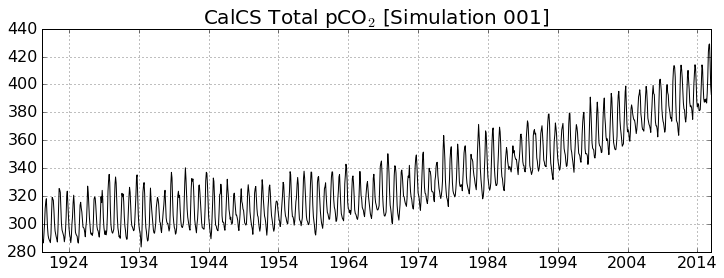

In [330]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
tot_pco2 = pco2_total['pCO2SURF_AW'][0].values
plt.plot(pco2_total['time'].values, tot_pco2, color='k')
ax.grid('on')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('CalCS Total pCO$_{2}$ [Simulation 001]', fontsize=20)
plt.savefig('calcs-total-pco2-001.png', dpi=300)

# Partitioned pCO2

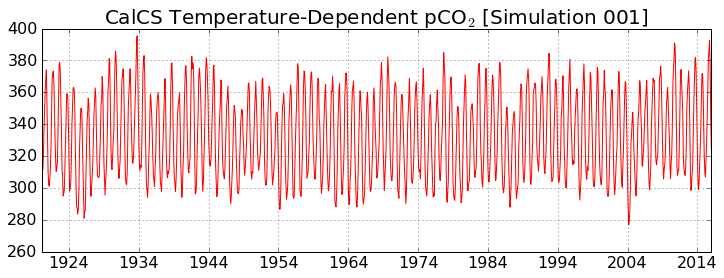

In [343]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
pCO2_Tplot = pCO2_T[0].values
plt.plot(pco2_total['time'].values, pCO2_Tplot, color='r')
ax.grid('on')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('CalCS Temperature-Dependent pCO$_{2}$ [Simulation 001]', fontsize=20)
plt.savefig('calcs-pCO2_T-pco2-001.png', dpi=300)

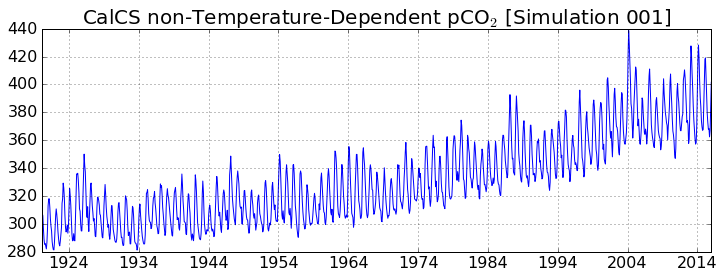

In [345]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
pCO2_nonTplot = pCO2_nonT[0].values
plt.plot(pco2_total['time'].values, pCO2_nonTplot, color='b')
ax.grid('on')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('CalCS non-Temperature-Dependent pCO$_{2}$ [Simulation 001]', fontsize=20)
plt.savefig('calcs-pCO2_nonT-pco2-001.png', dpi=300)

# Detrending PCO2 Components

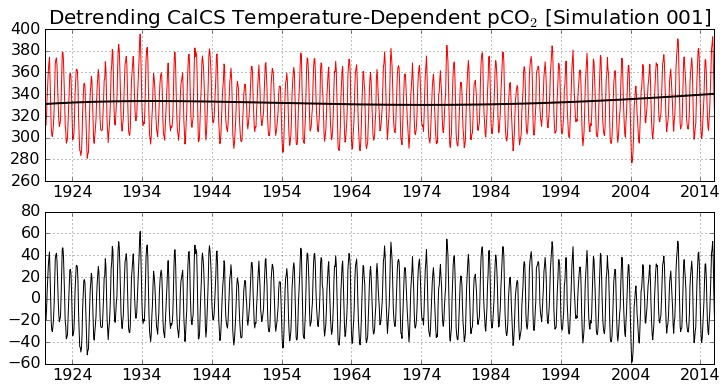

In [358]:
x = np.arange(0, len(y), 1)
y = pCO2_nonT[0].values

coeffs = np.polyfit(x, y, deg=4)
poly = np.poly1d(coeffs)
yp = np.polyval(poly, x)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(211)
plt.plot(pco2_total['time'].values, y, color='b')
plt.plot(pco2_total['time'].values, yp, color='k', lw=2)
ax.grid('on')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('Detrending CalCS Temperature-Dependent pCO$_{2}$ [Simulation 001]', fontsize=20)

ax2 = fig.add_subplot(212)
plt.plot(pco2_total['time'].values, (y-yp), color='k')
ax2.grid('on')
ax2.tick_params(axis='both', which='major', labelsize=16)
#plt.savefig('calcs-pCO2_T-pco2-detrending-001.png', dpi=300)